# World Energy Data



The Energy Statistics Database contains comprehensive energy statistics on the production, trade, conversion and final consumption of primary and secondary; conventional and non-conventional; and new and renewable sources of energy for the year  2014.

This dataset was kindly published by the United Nations Statistics Division on the **UNData site**.

*Per the UNData terms of use*: all data and metadata provided on UNdata’s website are available free of charge and may be copied freely, duplicated and further distributed provided that UNdata is cited as the reference. 


The Questionnaire is the primary source of information for the UNSD Energy Statistics Database and contributes
to the Energy Statistics Yearbook, the Energy Balances and the Electricity Profiles publications. The Energy
Statistics Yearbook is a comprehensive collection of internationally comparable data on the supply of energy. The
Energy Balances present energy data in a format showing an overall picture of energy production, trade,
conversion and consumption for energy products utilized in the country, while Electricity Profiles contains detailed
information on production, trade and consumption of electricity, net installed capacity and thermal power plant
inputs and efficiencies

# Analysis Goals

The main goal of this analysis is to investigate renewable energy data for each country and to determine its relation to country's wealth.

We will try to find answers for the following questions?
1. What is the amount of renewable energy production for each country?
2. Is country's renwable energy production relate to it's wealth?
3. What is the share of renewable energy per each country in it's electricity needs?
4. Can we pridect country's economic categry (developed or developing economy) using renewable enregy and Groth domestic Product (GPD) metrices?

In [1]:
# importing packages that will be used during the analysis
import pandas as pd
import numpy as np
from scipy.cluster import vq
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading the data file into pandas DataFrame
we = pd.read_csv('all_energy_statistics_2014.csv')
we.sample(10)

,Unnamed: 0,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
40080,851856,Pakistan,Natural gas liquids - Total energy supply,2014,"Metric tons, thousand",253.0,NaN,natural_gas_liquids
8697,173693,Australia,Conventional crude oil - final consumption,2014,"Metric tons, thousand",15.0,NaN,conventional_crude_oil
30884,657771,Greece,Liquefied petroleum gas (LPG) - Production,2014,"Metric tons, thousand",735.0,NaN,liquified_petroleum_gas
53863,1143104,Portugal,From chemical heat – Autoproducer,2014,"Kilowatt-hours, million",7.0,NaN,total_electricity
38115,811732,Bangladesh,Natural gas (including LNG) - final consumption,2014,Terajoules,381435.0,NaN,natural_gas_including_lng
51982,1098667,Djibouti,Electricity - Gross demand,2014,"Kilowatt-hours, million",396.0,1.0,total_electricity
30937,659172,Trinidad and Tobago,Liquefied petroleum gas (LPG) - Production,2014,"Metric tons, thousand",659.0,NaN,liquified_petroleum_gas
49813,1052511,Ireland,Electricity - Consumption by machinery,2014,"Kilowatt-hours, million",1400.0,NaN,total_electricity
19346,407713,Antigua and Barbuda,Gas Oil/ Diesel Oil - Consumption by transport,2014,"Metric tons, thousand",8.0,1.0,gas_oil_diesel_oil
28542,605954,Djibouti,Kerosene-type Jet Fuel - Total energy supply,2014,"Metric tons, thousand",0.0,1.0,kerosene_type_jet_fuel


In [3]:
# deleting un-nessecsary old index column 'Unnamed: 0'
del we['Unnamed: 0']

In [4]:
we.dtypes

country_or_area           object
commodity_transaction     object
year                       int64
unit                      object
quantity                 float64
quantity_footnotes       float64
category                  object
dtype: object

As observed from the sample data shown previously, **commodity_transaction** column combines the category with the transaction name. So a new column needs to be created to contain only the **transaction** without the redundant data from category,as it already has it's own column .

It can be noticed that each data cell contains the category followed by **'-'** and the transaction. Accordingly we will apply a function to split those strings and return the transaction only in a new column called ** transaction**

In [5]:
def split_comm_trans(df):
    def split_apply(x):
        s = str(x)
        s_l = s.split('-')
        return s_l[-1]
    df1 = df.copy()
    df1['transaction'] = df1['commodity_transaction'].apply(split_apply)
    return df1

#applying the split function
we = split_comm_trans(we)
del we['commodity_transaction']
we.head()

,country_or_area,year,unit,quantity,quantity_footnotes,category,transaction
0,Belgium,2014,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates,Exports
1,France,2014,"Metric tons, thousand",119.0,NaN,additives_and_oxygenates,Exports
2,Greece,2014,"Metric tons, thousand",2.0,NaN,additives_and_oxygenates,Exports
3,Italy,2014,"Metric tons, thousand",4.0,NaN,additives_and_oxygenates,Exports
4,Netherlands,2014,"Metric tons, thousand",390.0,NaN,additives_and_oxygenates,Exports


To align with the goal of this analysis, we will keep only data related to renweable energy sources as per UN definition which are:
  
  - ** 1.SOLAR ENERGY** it is the most abundant of all energy resources and can even be harnessed in cloudy weather
  - ** 2.WIND ENERGY** it harnesses the kinetic energy of moving air by using large wind turbines located on land (onshore) or in sea- or freshwater (offshore). 
  - ** 3.GEOTHERMAL ENERGY** it utilizes the accessible thermal energy from the Earth’s interior. Heat is extracted from geothermal reservoirs using wells or other means.
  - ** 4.HYDROPOWER** that derives from technologies that use the kinetic and thermal energy of seawater - waves or currents for instance -  to produce electricity or heat.
  - ** 5.OCEAN ENERGY** it derives from technologies that use the kinetic and thermal energy of seawater - waves or currents for instance -  to produce electricity or heat.
  - ** 6.BIOENERGY** which is produced from a variety of organic materials, called biomass, such as wood, charcoal, dung and other manures for heat and power production, and agricultural crops for liquid biofuels
  
**For the sack of our analysis, we will be mainly concerned with the production of the first five types of reneweable energy**

To accomplish this task we will examine the **category** column and extract the data that is relevant to the energy sources defined above.

In [6]:
we['category'].unique()

array(['additives_and_oxygenates', 'animal_waste', 'anthracite',
       'aviation_gasoline', 'bagasse', 'biodiesel', 'biogases',
       'biogasoline', 'bitumen', 'black_liquor', 'blast_furnace_gas',
       'brown_coal_briquettes', 'brown_coal', 'charcoal', 'coal_tar',
       'coke_oven_coke', 'coking_coal', 'conventional_crude_oil',
       'direct_use_of_geothermal_heat',
       'direct_use_of_solar_thermal_heat',
       'electricity_net_installed_capacity_of_electric_power_plants',
       'ethane', 'fuel_oil', 'fuelwood', 'gas_coke', 'gas_oil_diesel_oil',
       'gasoline_type_jet_fuel', 'gasworks_gas', 'geothermal',
       'hard_coal', 'heat', 'hydro', 'industrial_waste',
       'kerosene_type_jet_fuel', 'lignite', 'liquified_petroleum_gas',
       'lubricants', 'motor_gasoline', 'municipal_wastes', 'naphtha',
       'natural_gas_including_lng', 'natural_gas_liquids',
       'nuclear_electricity', 'of_which_biodiesel',
       'of_which_biogasoline', 'oil_shale_oil_sands',
       'oth

The following code cell will generate a new data frame called **we_ren** that contains only data relevant to renewable resources.

In [7]:
def keep_ren_energy(df):
    category_DOI = ['geothermal','hydro','solar_electricity','tide_wave_and_ocean_electricity',\
                    'wind_electricity','total_electricity']
    transaction_DOI = [' total wind production',' total hydro production',' total solar production',\
                       ' total geothermal production',' total tide, wave production',' Final energy consumption']
    df2 = df.copy()
    category_DOI_filt = df2['category'].isin(category_DOI)
    df2 = df2[category_DOI_filt]
    transaction_DOI_filt = df2['transaction'].isin(transaction_DOI)
    df2 = df2[transaction_DOI_filt]
    return df2

we_ren = keep_ren_energy(we)
we_ren.sample(5)

,country_or_area,year,unit,quantity,quantity_footnotes,category,transaction
51741,Comoros,2014,"Kilowatt-hours, million",43.5,1.0,total_electricity,Final energy consumption
51765,Fiji,2014,"Kilowatt-hours, million",782.6,NaN,total_electricity,Final energy consumption
26618,Cameroon,2014,"Kilowatt-hours, million",5068.0,NaN,hydro,total hydro production
51817,Luxembourg,2014,"Kilowatt-hours, million",6228.0,NaN,total_electricity,Final energy consumption
48491,Belgium,2014,"Kilowatt-hours, million",2883.0,NaN,solar_electricity,total solar production



Next, We will import our second data set that contain **GDP** data for each country in the world.

In [8]:
gdp = pd.read_csv('2014_world_gdp_with_codes.csv')
gdp.sample(5)

,COUNTRY,GDP (BILLIONS),CODE
135,Nicaragua,11.85,NIC
215,Anguilla,0.18,AIA
36,Israel,305,ISR
205,American Samoa,0.75,ASM
128,Zimbabwe,13.74,ZWE


https://unctadstat.unctad.org/EN/Classifications.html


Next, We will import our third data set that contain **Economic Category (Developed/ Developing Economy)** data for each country in the world.

In [9]:
classes = pd.read_excel('DimCountries_All_Hierarchy.xlsx')
classes.sample(5)

,Country,Classification
59,Zimbabwe,Developing
46,Seychelles,Developing
185,Vanuatu,Developing
188,Canada,Developed
16,Egypt,Developing



Then, a single data frame will be generated in which data from all data frames are merged together based on country name.

Also, the data columns needed for the analysis would be kept and renamed for easier analysis in the future


In [10]:
merged = we_ren.merge(gdp, left_on = ['country_or_area'], right_on = ['COUNTRY'])
merged = merged.merge(classes, left_on = ['COUNTRY'], right_on = ['Country'])
merged2 = merged[['country_or_area','year','unit','quantity','category','transaction','GDP (BILLIONS)','Classification']]\
    .rename(columns= {'country_or_area': 'country','GDP (BILLIONS)': 'GDP','Classification': 'classification'})
merged2.sample(5)

,country,year,unit,quantity,category,transaction,GDP,classification
405,T.F.Yug.Rep. Macedonia,2014,"Kilowatt-hours, million",1206.651,hydro,total hydro production,10.92,Developed
419,Ukraine,2014,"Kilowatt-hours, million",429.000,solar_electricity,total solar production,134.9,Developed
346,Paraguay,2014,"Kilowatt-hours, million",9794.600,total_electricity,Final energy consumption,31.3,Developing
166,Chile,2014,"Kilowatt-hours, million",1443.000,wind_electricity,total wind production,264.1,Developing
363,Rwanda,2014,"Kilowatt-hours, million",185.800,hydro,total hydro production,8,Developing



Next, we will inspect the GDP column we just insreted in our merged data frame


In [11]:
merged2.dtypes

country            object
year                int64
unit               object
quantity          float64
category           object
transaction        object
GDP                object
classification     object
dtype: object

It appears that the GDP column is not a number format (int or float), which indicate that there are some erroneous data exist in this column 

In [12]:
def type_check(x):
    
    try:
        x_f = float(x)
        error_val = False
    except:
        error_val = True
    return error_val

# checking erroneous values in the data
error_list = merged2['GDP'].apply(type_check)
merged2[error_list]

,country,year,unit,quantity,category,transaction,GDP,classification
81,Russian Federation,2014,"Kilowatt-hours, million",455.0,geothermal,total geothermal production,..,Developed
82,Russian Federation,2014,"Kilowatt-hours, million",177141.0,hydro,total hydro production,..,Developed
83,Russian Federation,2014,"Kilowatt-hours, million",160.0,solar_electricity,total solar production,..,Developed
84,Russian Federation,2014,"Kilowatt-hours, million",737830.0,total_electricity,Final energy consumption,..,Developed
85,Russian Federation,2014,"Kilowatt-hours, million",96.0,wind_electricity,total wind production,..,Developed


this analysis shows that the only missing GDP value is related to Russian Federation.
Russian Federation GDP value was brought from **https://www.statista.com/statistics/263772/gross-domestic-product-gdp-in-russia/** 
which is found to be 2048.84 Billion USD for the year 2014

Thus we will manually insert this value for Russian Federation to complete our GDP data and to convert this numbers into a suitable number format

In [13]:
merged2.replace('..','2048.84',inplace=True)
merged2.iloc[19:23]

# Next we will convert GDP column to float format

merged3 = merged2.astype({'GDP':'float'})
merged3.dtypes

country            object
year                int64
unit               object
quantity          float64
category           object
transaction        object
GDP               float64
classification     object
dtype: object


As we are intersted in analysing the total renewable energy as a variable for each country, it's needed to cast these sources from category column to make a sperate column for each energy source.
After that a single column would be created (**"total_RE_production"**) summing all energy production from renweable sources

In [14]:
def cast(df, key, value, join_how='outer'):
    """Casts the input data frame into a tibble,
    given the key column and value column.
    """
    assert type(df) is pd.DataFrame
    assert key in df.columns and value in df.columns
    assert join_how in ['outer', 'inner']
    
    fixed_vars = df.columns.difference([key, value])
    tibble = pd.DataFrame(columns=fixed_vars) 
    
    new_vars = df[key].unique()
    for v in new_vars:
        df_v = df[df[key] == v]
        del df_v[key]
        df_v = df_v.rename(columns={value: v})
        tibble = tibble.merge(df_v,
                              on=list(fixed_vars),
                              how=join_how)
    
    return tibble

# implement the cast function that will unpivot our data frame 
merged4 = cast(merged3[['country','year','unit','quantity','category','GDP','classification']],'category','quantity')

# convert NaN values to zeros
merged5 = merged4.fillna(0)

# re-ordering the columns 
merged5 = merged5[['country','year','GDP','classification','solar_electricity','wind_electricity'\
                   ,'hydro','geothermal','tide_wave_and_ocean_electricity','total_electricity']]
merged5.sample(5)

,country,year,GDP,classification,solar_electricity,wind_electricity,hydro,geothermal,tide_wave_and_ocean_electricity,total_electricity
136,American Samoa,2014,0.75,Developing,1.100000,0.0,0.0,0.0,0.0,134.769000
147,Niue,2014,0.01,Developing,0.066667,0.0,0.0,0.0,0.0,2.847778
114,Slovenia,2014,49.93,Developed,257.000000,4.0,6366.0,0.0,0.0,12459.000000
112,Sierra Leone,2014,5.41,Developing,0.000000,0.0,118.1,0.0,0.0,86.360000
27,Armenia,2014,10.88,Developing,0.000000,4.0,1992.0,0.0,0.0,5353.000000



Now we are going to create a new column to represent the total renewable energy production for each country based on the selected 5 renewable enrgy sources.

Simultaneously, we will generate a new column **RE_ration** to store the share of renewable energy for each country's electricity needs.


In [15]:
merged5['total_RE_prod'] = merged5.iloc[:,4:9].sum(axis=1)
merged5['RE_ratio'] = merged5['total_RE_prod'] / merged5['total_electricity']
merged5.sample(5)
merged5.sort_values(by='GDP',ascending=False)

,country,year,GDP,classification,solar_electricity,wind_electricity,hydro,geothermal,tide_wave_and_ocean_electricity,total_electricity,total_RE_prod,RE_ratio
20,United States,2014,17420.00,Developed,24603.000000,183892.00,281527.0,18710.0,0.0,3.787793e+06,5.087320e+05,0.134308
45,China,2014,10360.00,Developing,15189.000000,156078.00,1064337.0,0.0,0.0,4.686376e+06,1.235604e+06,0.263659
10,Japan,2014,4770.00,Developed,24506.000000,5038.00,86942.0,2577.0,0.0,9.514870e+05,1.190630e+05,0.125134
5,Germany,2014,3820.00,Developed,36056.000000,57357.00,25444.0,98.0,0.0,5.128350e+05,1.189550e+05,0.231956
61,France,2014,2902.00,Developed,5909.000000,17249.00,68626.0,0.0,481.0,4.153250e+05,9.226500e+04,0.222151
...,...,...,...,...,...,...,...,...,...,...,...,...
144,Marshall Islands,2014,0.18,Developing,0.200000,0.00,0.0,0.0,0.0,7.420000e+01,2.000000e-01,0.002695
177,Kiribati,2014,0.16,Developing,0.000000,0.00,0.0,0.0,0.0,2.290000e+01,0.000000e+00,0.000000
170,Falkland Is. (Malvinas),2014,0.16,Developing,0.000000,5.69,0.0,0.0,0.0,1.765000e+01,5.690000e+00,0.322380
195,Tuvalu,2014,0.04,Developing,0.000000,0.00,0.0,0.0,0.0,5.100000e+00,0.000000e+00,0.000000



Next, we will visually inspect GPD and total renewable production per country to determine the relation between country's GDP and their renewable energy production


<AxesSubplot:xlabel='country', ylabel='total_RE_prod'>

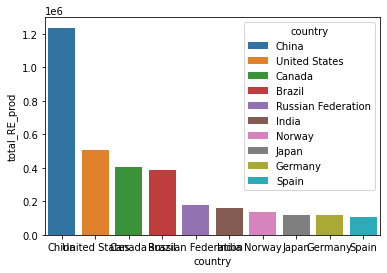

In [16]:
# plotting electricity production from renewable resources

cont_gdp = merged5.groupby('country', as_index=False)['total_RE_prod'].sum()\
.sort_values(by='total_RE_prod',ascending=False).head(10)
sns.barplot(data = cont_gdp,x='country',y='total_RE_prod' ,hue='country',dodge=False)

<AxesSubplot:xlabel='country', ylabel='GDP'>

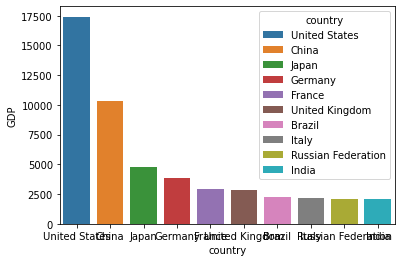

In [17]:
# plotting GDP 

cont_prod = merged5.groupby('country', as_index=False)['GDP'].sum()\
.sort_values(by='GDP',ascending=False).head(10)
sns.barplot(data = cont_prod,x='country',y='GDP' ,hue='country',dodge=False)

<AxesSubplot:xlabel='country', ylabel='total_electricity'>

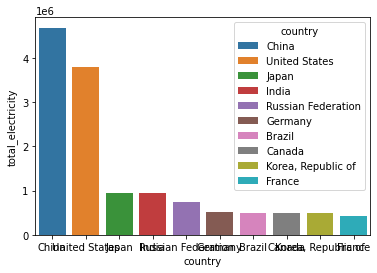

In [18]:
# plotting electricity consumption 

cont_prod = merged5.groupby('country', as_index=False)['total_electricity'].sum()\
.sort_values(by='total_electricity',ascending=False).head(10)
sns.barplot(data = cont_prod,x='country',y='total_electricity' ,hue='country',dodge=False)


From the charts above we can see that there is a postive correlation between electricity consumption, GDP and electricity production from renewable resources. 

This evident in countries like ( United States, China, Japan, Russia, Germany, India), Which exit in top 10 countries of renewable enrgy production, electricity consumption and GDP.

However; deeper analysis is needed to investigate this relation in more details

# Kmeans clustring model

As to answer the question about how we could create a model to predict country's economic wealth based on the data available, we shall use a Kmeans clustring approach to try accomplishing this goal.

We will now create a new column **economic_rank** to store country's economic classification as integer representation of 1 & 0 to help in comparing the model outputs with the pre-known classification labels.
1 will be assigned to **Developed** countries and 0 for **Developing** countries


In [19]:
def econ_categorize(x):
    cat = 0
    if x == 'Developed':
        cat = 1      
    return cat
merged6 = merged5.copy()
merged6['economic_rank'] = merged5['classification'].apply(econ_categorize)
merged6.sample(10)

,country,year,GDP,classification,solar_electricity,wind_electricity,hydro,geothermal,tide_wave_and_ocean_electricity,total_electricity,total_RE_prod,RE_ratio,economic_rank
38,Burkina Faso,2014,13.38,Developing,0.0,0.0,90.473,0.0,0.0,1123.353,90.473,0.080538,0
174,Guam,2014,4.60,Developing,0.0,0.0,0.000,0.0,0.0,1578.000,0.000,0.000000,0
84,Lesotho,2014,2.46,Developing,0.0,0.0,515.200,0.0,0.0,685.000,515.200,0.752117,0
112,Sierra Leone,2014,5.41,Developing,0.0,0.0,118.100,0.0,0.0,86.360,118.100,1.367531,0
120,Suriname,2014,5.27,Developing,0.0,0.0,795.100,0.0,0.0,1955.400,795.100,0.406618,0
37,Bulgaria,2014,55.08,Developed,1252.0,1331.0,5163.000,0.0,0.0,27674.000,7746.000,0.279902,1
143,Malta,2014,10.57,Developed,68.0,0.0,0.000,0.0,0.0,2032.000,68.000,0.033465,1
168,Cook Islands,2014,0.18,Developing,0.0,0.0,0.000,0.0,0.0,31.800,0.000,0.000000,0
60,Finland,2014,276.30,Developed,8.0,1107.0,13397.000,0.0,0.0,79137.000,14512.000,0.183378,1
102,Panama,2014,44.69,Developing,1.3,116.3,5033.800,0.0,0.0,7831.600,5151.400,0.657771,0



Now we will define some functions to aid in the process of visualizing and quality check the model outputs


None
None


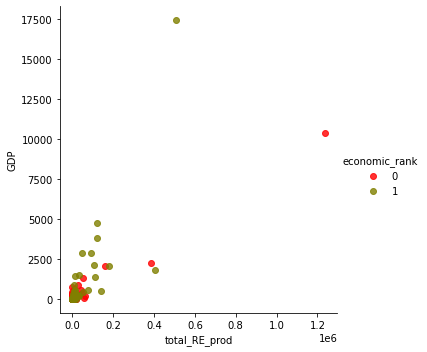

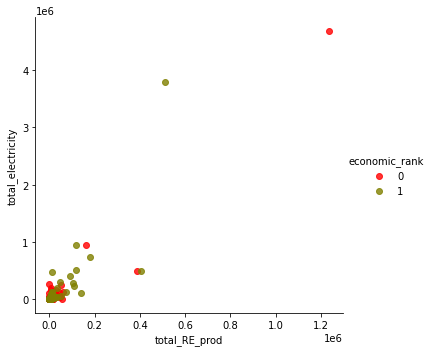

In [20]:
def make_scatter_plot(df, x="total_RE_prod", y="GDP", hue="economic_rank",
                      palette={0: "red", 1: "olive", 2: "blue", 3:"yellow"},
                      size=5):
    sns.lmplot(x=x, y=y, hue=hue, data=df, palette=palette,
               fit_reg=False)
    
def count_matches(a, b, exact=False):

    matches = mark_matches(a, b, exact=exact)
    return int(matches.sum())

def mark_matches(a, b, exact=False):

    assert a.shape == b.shape
    a_int = a.astype(dtype=int)
    b_int = b.astype(dtype=int)
    all_axes = tuple(range(len(a.shape)))
    assert ((a_int == 0) | (a_int == 1)).all()
    assert ((b_int == 0) | (b_int == 1)).all()
    
    exact_matches = (a_int == b_int)
    if exact:
        return exact_matches

    assert exact == False
    num_exact_matches = np.sum(exact_matches)
    if (2*num_exact_matches) >= np.prod(a.shape):
        return exact_matches
    return exact_matches == False # Invert

print(make_scatter_plot(merged6, x='total_RE_prod', y='GDP'))
print(make_scatter_plot(merged6, x='total_RE_prod', y='total_electricity'))


Next, we will choose total renewable energy production and total electricity consumption to train the kmeans clustring model as below:


In [21]:
points = vq.whiten(merged6[['total_RE_prod','total_electricity']].values)
labels = merged6['economic_rank'].values
n, d = points.shape
k = 2

Centers:
 [[2.83905981 2.57073853]
 [0.05966057 0.06398653]]
Distortion (WCSS): 0.2604347117046191
148 matches out of 198 possible (~ 74.7%)


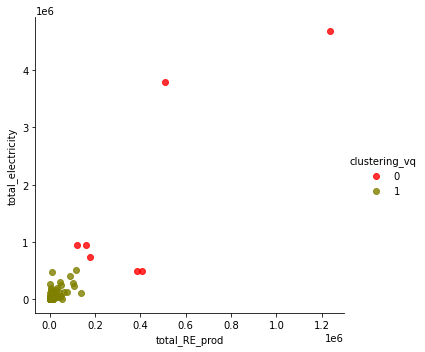

In [22]:
from scipy.cluster import vq

centers_vq1, distortion_vq1 = vq.kmeans(points, k, iter=100, thresh=.05,seed=4)
clustering_vq1, _ = vq.vq(points, centers_vq1)
print("Centers:\n", centers_vq1)
# print("\nCompare with your method:\n", centers, "\n")
print("Distortion (WCSS):", distortion_vq1)

# inverting_clusters_labeles

merged6['clustering_vq'] = clustering_vq1
make_scatter_plot(merged6,x='total_RE_prod', y='total_electricity', hue='clustering_vq')

n_matches_vq = count_matches(merged6['economic_rank'], merged6['clustering_vq'])
print(n_matches_vq,
      "matches out of",
      len(merged6), "possible",
      "(~ {:.1f}%)".format(100.0 * n_matches_vq / len(merged6)))

In [23]:
merged6.sample(20)

,country,year,GDP,classification,solar_electricity,wind_electricity,hydro,geothermal,tide_wave_and_ocean_electricity,total_electricity,total_RE_prod,RE_ratio,economic_rank,clustering_vq
130,Uruguay,2014,55.60,Developing,3.40,732.60,9649.10,0.0,0.0,10132.100,10385.10,1.024970,0,1
168,Cook Islands,2014,0.18,Developing,0.00,0.00,0.00,0.0,0.0,31.800,0.00,0.000000,0,1
71,Hungary,2014,129.70,Developed,56.00,657.00,302.00,0.0,0.0,34704.000,1015.00,0.029247,1,1
18,Russian Federation,2014,2048.84,Developed,160.00,96.00,177141.00,455.0,0.0,737830.000,177852.00,0.241047,1,0
114,Slovenia,2014,49.93,Developed,257.00,4.00,6366.00,0.0,0.0,12459.000,6627.00,0.531905,1,1
139,Cabo Verde,2014,1.98,Developing,5.02,65.67,0.00,0.0,0.0,295.400,70.69,0.239303,0,1
169,Djibouti,2014,1.58,Developing,0.00,0.00,0.00,0.0,0.0,305.000,0.00,0.000000,0,1
42,Canada,2014,1794.00,Developed,1756.00,22538.00,382574.00,0.0,16.0,489239.000,406884.00,0.831667,1,0
129,United Rep. of Tanzania,2014,36.62,Developing,18.00,0.00,2590.00,0.0,0.0,4976.000,2608.00,0.524116,0,1
152,St. Kitts-Nevis,2014,0.81,Developing,1.00,8.00,0.00,0.0,0.0,180.000,9.00,0.050000,0,1


Although the model shows around 78% prediction accuracy, it still not enough to use this model to predict country's economic wealth based on thier electricity consumtion and production from renweable resources.

The model needs to encounter some other metrices that may affect country's renewable energy production like:
1. **geographic location**
2. **availabilty of renewable resources**
3. **population**
4. **abundance of conventional resources**

When this data is encorporated in the model. it may enhance the prediction results

This is the end of our analysis..Hope you enjoyed this quick journey
**THANK YOU**